# Build and deploy forecasting models with Azure Machine Learning

In this article, learn how to use **Azure Machine Learning Package for Forecasting** (AMLPF) to quickly build and deploy a forecasting model. The workflow is as follows:

1. Load and explore data
2. Create features
3. Train and select the best model
4. Deploy the model and consume the web service

Consult the [package reference documentation](https://aka.ms/aml-packages/forecasting) for the full list of transformers and models as well as the detailed reference for each module and class.

## Prerequisites

1. If you don't have an Azure subscription, create a [free account](https://azure.microsoft.com/free/?WT.mc_id=A261C142F) before you begin.

1. The following accounts and application must be set up and installed:
   - An Azure Machine Learning Experimentation account 
   - An Azure Machine Learning Model Management account
   - Azure Machine Learning Workbench installed 
   
1. The Azure Machine Learning Package for Forecasting must be installed. Learn how to [install this package here](https://aka.ms/aml-packages/forecasting).



## Sample data and Jupyter notebook

### Sample workflow 
The example follows the workflow:
 
1. **Ingest Data**: Load the dataset and convert it into TimeSeriesDataFrame. This dataframe is a time series data structure provided by Azure Machine Learning Package for Forecasting, herein referred to as **AMLPF**.

2. **Create Features**: Use various featurization transformers provided by AMLPF to create features.

3. **Train and Select Best Model**: Compare the performance of various univariate time series models and machine learning models. 

4. **Deploy Model**: Deploy the trained model pipeline as a web service via Azure Machine Learning Workbench so it can be consumed by others.


### Explore the sample data

The machine learning forecasting examples in the follow code samples rely on the [University of Chicago's Dominick's Finer Foods dataset](https://research.chicagobooth.edu/kilts/marketing-databases/dominicks) to forecast orange juice sales. Dominick's was a grocery chain in the Chicago metropolitan area.




### Import any dependencies for this sample

These dependencies must be imported for the following code samples

In [1]:
import warnings

# Suppress warnings
warnings.filterwarnings("ignore") 

import pandas as pd
import numpy as np
import math
import pkg_resources
from datetime import timedelta
import matplotlib
matplotlib.use('agg')
from matplotlib import pyplot as plt

from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from ftk import TimeSeriesDataFrame, ForecastDataFrame, AzureMLForecastPipeline
from ftk.tsutils import last_n_periods_split

from ftk.transforms import TimeSeriesImputer, TimeIndexFeaturizer, DropColumns
from ftk.transforms.grain_index_featurizer import GrainIndexFeaturizer
from ftk.models import Arima, SeasonalNaive, Naive, RegressionForecaster, ETS
from ftk.models.forecasterunion import ForecasterUnion
from ftk.model_selection import TSGridSearchCV, RollingOriginValidator

from azuremltkbase.deployment import AMLSettings
from ftk.operationalization.forecast_webservice_factory import ForecastWebserviceFactory
from ftk.operationalization import ScoreContext

from ftk.data import get_a_year_of_daily_weather_data
print('imports done')

imports done


## Load data and explore

This code snippet shows the typical process of starting with a raw data set, in this case the [data from Dominick's Finer Foods](https://research.chicagobooth.edu/kilts/marketing-databases/dominicks).  You can also use the convenience function [load_dominicks_oj_data](https://docs.microsoft.com/en-us/python/api/ftk.data.dominicks_oj.load_dominicks_oj_data).

In [2]:
# Load the data into a pandas DataFrame
csv_path = pkg_resources.resource_filename('ftk', 'data/dominicks_oj/dominicks_oj.csv')
whole_df = pd.read_csv(csv_path, low_memory = False)
whole_df.head()

,store,brand,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0,2,tropicana,40,9.02,0,3.87,0.23,0.25,0.11,10.55,0.10,0.30,0.46,2.11,1.14,1.93,0.38
1,2,tropicana,46,8.72,0,3.87,0.23,0.25,0.11,10.55,0.10,0.30,0.46,2.11,1.14,1.93,0.38
2,2,tropicana,47,8.25,0,3.87,0.23,0.25,0.11,10.55,0.10,0.30,0.46,2.11,1.14,1.93,0.38
3,2,tropicana,48,8.99,0,3.87,0.23,0.25,0.11,10.55,0.10,0.30,0.46,2.11,1.14,1.93,0.38
4,2,tropicana,50,9.09,0,3.87,0.23,0.25,0.11,10.55,0.10,0.30,0.46,2.11,1.14,1.93,0.38


The data consist of weekly sales by brand and store. The logarithm of the quantity sold is in the _logmove_ column. The data also includes some customer demographic features. 

To model the time series, you need to extract the following elements from this dataframe: 
+ A date/time axis 
+ The sales quantity to be forecast

In [3]:
# The sales are contained in the 'logmove' column. 
# Values are logarithmic, so exponentiate and round them to get quantity sold
def expround(x):
    return math.floor(math.exp(x) + 0.5)
whole_df['Quantity'] = whole_df['logmove'].apply(expround)

# The time axis is in the 'week' column
# This is the week offset from the week of 1989-09-07 through 1989-09-13 inclusive
# Create new datetime columns containing the start and end of each week period
weekZeroStart = pd.to_datetime('1989-09-07 00:00:00')
weekZeroEnd = pd.to_datetime('1989-09-13 23:59:59')
whole_df['WeekFirstDay'] = whole_df['week'].apply(lambda n: weekZeroStart + timedelta(weeks=n))
whole_df['WeekLastDay'] = whole_df['week'].apply(lambda n: weekZeroEnd + timedelta(weeks=n))
whole_df[['store','brand','WeekLastDay','Quantity']].head()

,store,brand,WeekLastDay,Quantity
0,2,tropicana,1990-06-20 23:59:59,8256
1,2,tropicana,1990-08-01 23:59:59,6144
2,2,tropicana,1990-08-08 23:59:59,3840
3,2,tropicana,1990-08-15 23:59:59,8000
4,2,tropicana,1990-08-29 23:59:59,8896


In [4]:
nseries = whole_df.groupby(['store', 'brand']).ngroups
print('{} time series in the data frame.'.format(nseries))

249 time series in the data frame.


The data contains approximately 250 different combinations of store and brand in a data frame. Each combination defines its own time series of sales. 

You can use the [TimeSeriesDataFrame](https://docs.microsoft.com/python/api/ftk.dataframets.timeseriesdataframe)  class to conveniently model multiple series in a single data structure using the _grain_. The grain is specified by the `store` and `brand` columns.

The difference between _grain_ and _group_ is that grain is always physically meaningful in the real world, while group doesn't have to be. Internal package functions use group to build a single model from multiple time series if the user believes this grouping helps improve model performance. By default, group is set to be equal to grain, and a single model is built for each grain. 

In [5]:
# Create a TimeSeriesDataFrame
# Use end of period as the time index
# Store and brand combinations label the grain 
# i.e. there is one time series for each unique pair of store and grain
whole_tsdf = TimeSeriesDataFrame(whole_df, 
                                 grain_colnames=['store', 'brand'],
                                 time_colname='WeekLastDay', 
                                 ts_value_colname='Quantity',
                                 group_colnames='store')

whole_tsdf[['Quantity']].head()

,,,Quantity
WeekLastDay,store,brand,
1990-06-20 23:59:59,2,tropicana,8256
1990-08-01 23:59:59,2,tropicana,6144
1990-08-08 23:59:59,2,tropicana,3840
1990-08-15 23:59:59,2,tropicana,8000
1990-08-29 23:59:59,2,tropicana,8896


In the TimeSeriesDataFrame representation, the time axis and grain are now part of the data frame index, and allow easy access to pandas datetime slicing functionality.

In [6]:
# sort so we can slice
whole_tsdf.sort_index(inplace=True)

# Get sales of dominick's brand orange juice from store 2 during summer 1990
whole_tsdf.loc[pd.IndexSlice['1990-06':'1990-09', 2, 'dominicks'], ['Quantity']]

,,,Quantity
WeekLastDay,store,brand,
1990-06-20 23:59:59,2,dominicks,10560
1990-08-01 23:59:59,2,dominicks,8000
1990-08-08 23:59:59,2,dominicks,6848
1990-08-15 23:59:59,2,dominicks,2880
1990-08-29 23:59:59,2,dominicks,1600
1990-09-05 23:59:59,2,dominicks,25344
1990-09-12 23:59:59,2,dominicks,10752
1990-09-19 23:59:59,2,dominicks,6656
1990-09-26 23:59:59,2,dominicks,6592


The [TimeSeriesDataFrame.ts_report](https://docs.microsoft.com/en-us/python/api/ftk.dataframets.timeseriesdataframe#ts-report) function generates a comprehensive report of the time series data frame. The report includes both a general data description as well as statistics specific to time series data. 

--------------------------------  Data Overview  ---------------------------------
<class 'ftk.dataframets.TimeSeriesDataFrame'>
MultiIndex: 28947 entries, (1990-06-20 23:59:59, 2, dominicks) to (1992-10-07 23:59:59, 137, tropicana)
Data columns (total 17 columns):
week            28947 non-null int64
logmove         28947 non-null float64
feat            28947 non-null int64
price           28947 non-null float64
AGE60           28947 non-null float64
EDUC            28947 non-null float64
ETHNIC          28947 non-null float64
INCOME          28947 non-null float64
HHLARGE         28947 non-null float64
WORKWOM         28947 non-null float64
HVAL150         28947 non-null float64
SSTRDIST        28947 non-null float64
SSTRVOL         28947 non-null float64
CPDIST5         28947 non-null float64
CPWVOL5         28947 non-null float64
Quantity        28947 non-null int64
WeekFirstDay    28947 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(13), int64(3)
memory usage: 3.8+ MB

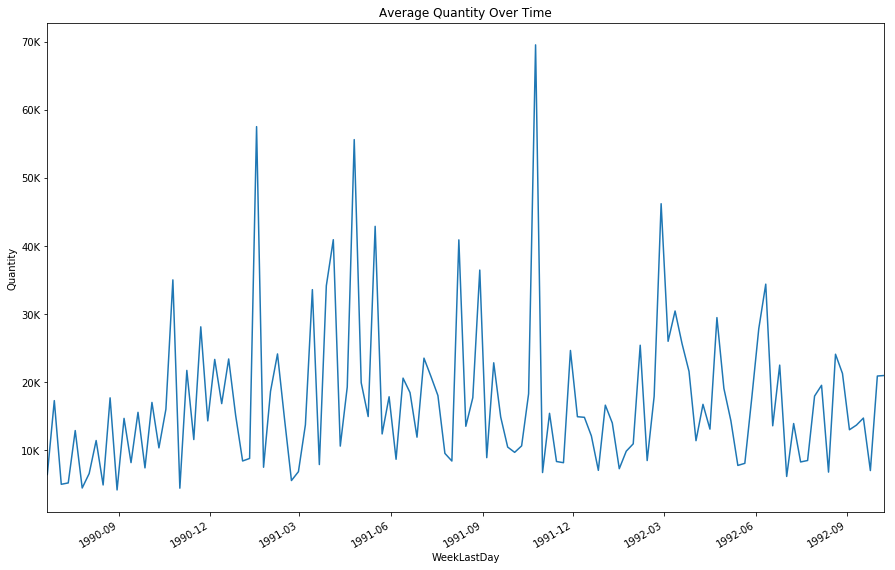

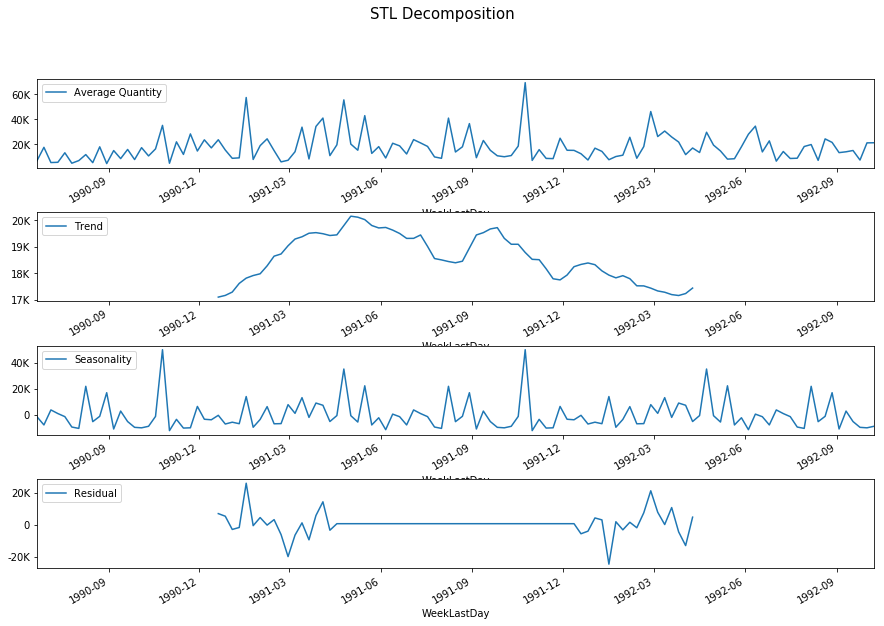

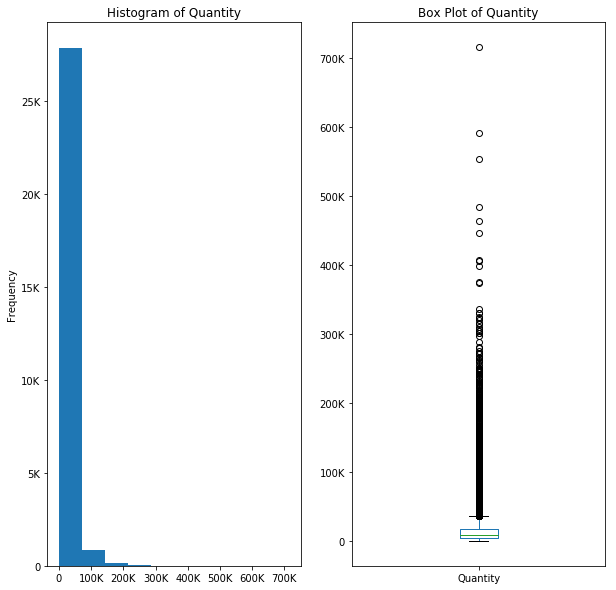

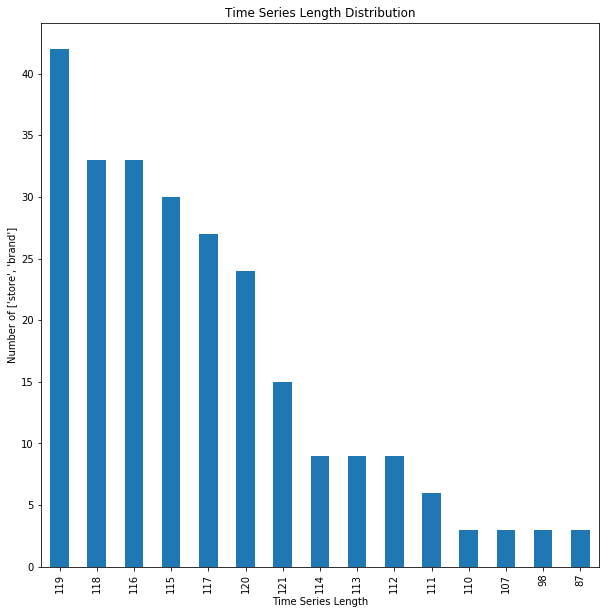

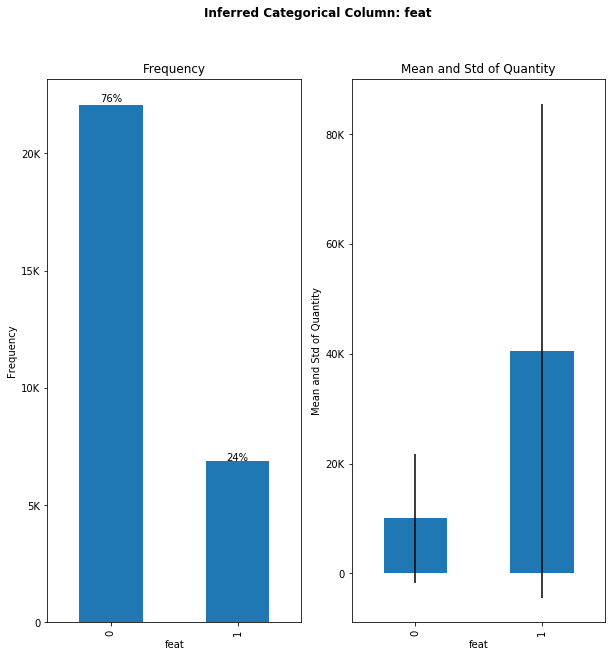

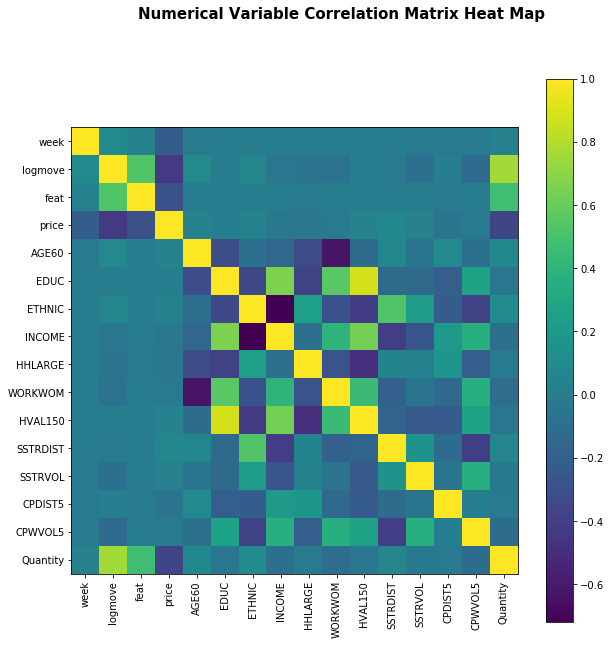

In [7]:
%matplotlib inline
whole_tsdf.ts_report()

## Integrate with External Data

Sometimes it's useful to integrate external data as additional features for forecasting. In this code sample, you join TimeSeriesDataFrame with external data related to weather.

In [8]:
# Load weather data
weather_1990 = get_a_year_of_daily_weather_data(year=1990)
weather_1991 = get_a_year_of_daily_weather_data(year=1991)
weather_1992 = get_a_year_of_daily_weather_data(year=1992)

# Preprocess weather data
weather_all = pd.concat([weather_1990, weather_1991, weather_1992])
weather_all.reset_index(inplace=True)

# Only use a subset of columns
weather_all = weather_all[['TEMP', 'DEWP', 'WDSP', 'PRCP']]

# Compute the WeekLastDay column, in order to merge with sales data
weather_all['WeekLastDay'] = pd.Series(
    weather_all.time_index - weekZeroStart, 
    index=weather_all.time_index).apply(lambda n: weekZeroEnd + timedelta(weeks=math.floor(n.days/7)))

# Resample daily weather data to weekly data
weather_all = weather_all.groupby('WeekLastDay').mean()

# Set WeekLastDay as new time index
weather_all = TimeSeriesDataFrame(weather_all, time_colname='WeekLastDay')

# Merge weather data with sales data
whole_tsdf = whole_tsdf.merge(weather_all, how='left', on='WeekLastDay')
whole_tsdf.head()

week  logmove  feat  price  AGE60  \
WeekLastDay         store brand                                            
1990-06-20 23:59:59 2     dominicks      40     9.26     1   1.59   0.23   
                          minute.maid    40     8.41     0   3.17   0.23   
                          tropicana      40     9.02     0   3.87   0.23   
                    5     dominicks      40     7.49     1   1.59   0.12   
                          minute.maid    40     8.35     0   2.99   0.12   

                                       EDUC  ETHNIC  INCOME  HHLARGE  WORKWOM  \
WeekLastDay         store brand                                                 
1990-06-20 23:59:59 2     dominicks    0.25    0.11   10.55     0.10     0.30   
                          minute.maid  0.25    0.11   10.55     0.10     0.30   
                          tropicana    0.25    0.11   10.55     0.10     0.30   
                    5     dominicks    0.32    0.05   10.92     0.10     0.41   
                          minute.maid  0.32    0.05   10.92     0.10     0.41   

                                       ...   SSTRDIST  SSTRVOL  CPDIST5  \
WeekLastDay         store brand        ...                                
1990-06-20 23:59:59 2     dominicks    ...       2.11     1.14     1.93   
                          minute.maid  ...       2.11     1.14     1.93   
                          tropicana    ...       2.11     1.14     1.93   
                    5     dominicks    ...       3.80     0.68     1.60   
                          minute.maid  ...       3.80     0.68     1.60   

                                       CPWVOL5  Quantity  WeekFirstDay  TEMP  \
WeekLastDay         store brand                                                
1990-06-20 23:59:59 2     dominicks       0.38     10560    1990-06-14 72.00   
                          minute.maid     0.38      4480    1990-06-14 72.00   
                          tropicana       0.38      8256    1990-06-14 72.00   
                    5     dominicks       0.74      1792    1990-06-14 72.00   
                          minute.maid     0.74      4224    1990-06-14 72.00   

                                       DEWP  WDSP  PRCP  
WeekLastDay         store brand                          
1990-06-20 23:59:59 2     dominicks   61.87  9.74  0.19  
                          minute.maid 61.87  9.74  0.19  
                          tropicana   61.87  9.74  0.19  
                    5     dominicks   61.87  9.74  0.19  
                          minute.maid 61.87  9.74  0.19  

[5 rows x 21 columns]

## Data preprocessing - impute missing values

Start by splitting the data into training set and a testing set with the [ftk.tsutils.last_n_periods_split](https://docs.microsoft.com/python/api/ftk.tsutils) utility function. The resulting testing set contains the last 40 observations of each time series. 

In [9]:
train_tsdf, test_tsdf = last_n_periods_split(whole_tsdf, 40)

Basic time series models require contiguous time series. Check to see if the series are regular, meaning that they have a time index sampled at regular intervals, using the [check_regularity_by_grain](https://docs.microsoft.compython/api/ftk.dataframets.timeseriesdataframe) function.

In [10]:
ts_regularity = train_tsdf.check_regularity_by_grain()
print(ts_regularity[ts_regularity['regular'] == False])

                                          problems  regular
store brand                                                
2     dominicks    [Irregular datetime gaps exist]    False
      minute.maid  [Irregular datetime gaps exist]    False
      tropicana    [Irregular datetime gaps exist]    False
5     dominicks    [Irregular datetime gaps exist]    False
      minute.maid  [Irregular datetime gaps exist]    False
      tropicana    [Irregular datetime gaps exist]    False
8     dominicks    [Irregular datetime gaps exist]    False
      minute.maid  [Irregular datetime gaps exist]    False
      tropicana    [Irregular datetime gaps exist]    False
9     dominicks    [Irregular datetime gaps exist]    False
      minute.maid  [Irregular datetime gaps exist]    False
      tropicana    [Irregular datetime gaps exist]    False
12    dominicks    [Irregular datetime gaps exist]    False
      minute.maid  [Irregular datetime gaps exist]    False
      tropicana    [Irregular datetime g

You can see that most of the series (213 out of 249) are irregular. An [imputation transform](https://docs.microsoft.com/python/api/ftk.transforms.tsimputer.timeseriesimputer) is required to fill in missing sales quantity values. While there are many imputation options, the following sample code uses a linear interpolation.

In [11]:
# Use a TimeSeriesImputer to linearly interpolate missing values
imputer = TimeSeriesImputer(input_column='Quantity', 
                            option='interpolate',
                            method='linear',
                            freq='W-WED')

train_imputed_tsdf = imputer.transform(train_tsdf)

After the imputation code is run, the series all have a regular frequency:

In [12]:
ts_regularity_imputed = train_imputed_tsdf.check_regularity_by_grain()
print(ts_regularity_imputed[ts_regularity_imputed['regular'] == False])

Empty DataFrame
Columns: [problems, regular]
Index: []


## Univariate Time Series Models

Now that you have cleaned up the data, you can begin modeling.  Start by creating three univariate models: the "naive" model, the "seasonal naive" model, and an "ARIMA" model.
* The Naive forecasting algorithm uses the actual target variable value of the last period as the forecasted value of the current period.

* The Seasonal Naive algorithm uses the actual target variable value of the same time point of the previous season as the forecasted value of the current time point. Some examples include using the actual value of the same month of last year to forecast months of the current year; use the same hour of yesterday to forecast hours today. 

* The exponential smoothing (ETS) algorithm generates forecasts by computing the weighted averages of past observations, with the weights decaying exponentially as the observations get older. 

* The AutoRegressive Integrated Moving Average (ARIMA) algorithm captures the autocorrelation in time series data. For more information about ARIMA, see [this link](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)

Start by setting certain model parameters based on your data exploration. 

In [13]:
oj_series_freq = 'W-WED'
oj_series_seasonality = 52

### Initialize Models

In [14]:
# Initialize naive model.
naive_model = Naive(freq=oj_series_freq)

# Initialize seasonal naive model. 
seasonal_naive_model = SeasonalNaive(freq=oj_series_freq, 
                                     seasonality=oj_series_seasonality)

# Initialize ETS model.
ets_model = ETS(freq=oj_series_freq, seasonality=oj_series_seasonality)

# Initialize ARIMA(p,d,q) model.
arima_order = [2, 1, 0]
arima_model = Arima(oj_series_freq, arima_order)

### Combine Multiple Models

The [ForecasterUnion](https://docs.microsoft.com/python/api/ftk.models.forecasterunion.forecasterunion) estimator allows you to combine multiple estimators and fit/predict on them using one line of code.

In [15]:
forecaster_union = ForecasterUnion(
    forecaster_list=[('naive', naive_model), ('seasonal_naive', seasonal_naive_model), 
                     ('ets', ets_model), ('arima', arima_model)]) 

### Fit and Predict

The estimators in AMLPF follow the same API as scikit-learn estimators: a fit method for model training and a predict method for generating forecasts. 

**Train models**  
Since these models are all univariate models, one model is fit to each grain of the data. Using AMLPF, all 249 models can be fit with just one function call.

In [17]:
forecaster_union_fitted = forecaster_union.fit(train_imputed_tsdf)

**Forecast sales on test data**  
Similar to the fit method, you can create predictions for all 249 series in the testing data set with one call to the `predict` function. 

In [19]:
forecaster_union_prediction = forecaster_union_fitted.predict(test_tsdf, retain_feature_column=True)

**Evaluate model performance**   

Now you can calculate the forecast errors on the test set. You can use the mean absolute percentage error (MAPE) here. MAPE is the mean absolute percent error relative to the actual sales values. The ```calc_error``` function provides a few built-in functions for commonly used error metrics. You can also define our custom error function to calculate MedianAPE and pass it to the err_fun argument.

In [20]:
def calc_median_ape(y_true, y_pred):
    y_true = np.array(y_true).astype(float)
    y_pred = np.array(y_pred).astype(float)
    y_true_rm_na = y_true[~(np.isnan(y_true) | np.isnan(y_pred))]
    y_pred_rm_na = y_pred[~(np.isnan(y_true) | np.isnan(y_pred))]
    y_true = y_true_rm_na
    y_pred = y_pred_rm_na
    if len(y_true) == 0:
        # if there is no entries left after removing na data, return np.nan
        return(np.nan)
    y_true_rm_zero = y_true[y_true != 0]
    y_pred_rm_zero = y_pred[y_true != 0]
    if len(y_true_rm_zero) == 0:
        # if all values are zero, np.nan will be returned.
        return(np.nan)
    ape = np.abs((y_true_rm_zero - y_pred_rm_zero) / y_true_rm_zero) * 100
    median_ape = np.median(ape)
    return median_ape

In [21]:
forecaster_union_MAPE = forecaster_union_prediction.calc_error(err_name='MAPE',
                                                               by='ModelName')
forecaster_union_MedianAPE = forecaster_union_prediction.calc_error(err_name='MedianAPE', 
                                                                    err_fun=calc_median_ape,
                                                                    by='ModelName')

univariate_model_errors = forecaster_union_MAPE.merge(forecaster_union_MedianAPE, on='ModelName')
univariate_model_errors

,ModelName,MAPE,MedianAPE
0,arima,126.57,66.49
1,ets,187.89,75.73
2,naive,103.57,59.14
3,seasonal_naive,180.54,65.99


## Machine Learning Models

In addition to traditional univariate models, Azure Machine Learning Package for Forecasting also enables you to create machine learning models.

For these models, begin by creating features.

### Feature Engineering

**Transformers**   
The package provides many transformers for time series data preprocessing and featurization. The examples that follow demonstrate some of the preprocessing and featurization functionality.

In [22]:
# DropColumns: Drop columns that should not be included for modeling. `logmove` is the log of the number of 
# units sold, so providing this number would be cheating. `WeekFirstDay` would be 
# redundant since we already have a feature for the last day of the week.
columns_to_drop = ['logmove', 'WeekFirstDay', 'week']
column_dropper = DropColumns(columns_to_drop)

# TimeSeriesImputer: Fill missing values in the features
# First, we need to create a dictionary with key as column names and value as values used to fill missing 
# values for that column. We are going to use the mean to fill missing values for each column.
columns_with_missing_values = train_imputed_tsdf.columns[pd.DataFrame(train_imputed_tsdf).isnull().any()].tolist()
columns_with_missing_values = [c for c in columns_with_missing_values if c not in columns_to_drop]
missing_value_imputation_dictionary = {}
for c in columns_with_missing_values:
    missing_value_imputation_dictionary[c] = train_imputed_tsdf[c].mean()
fillna_imputer = TimeSeriesImputer(option='fillna', 
                                   input_column=columns_with_missing_values,
                                   value=missing_value_imputation_dictionary)

# TimeIndexFeaturizer: extract temporal features from timestamps
time_index_featurizer = TimeIndexFeaturizer(correlation_cutoff=0.1, overwrite_columns=True)

# GrainIndexFeaturizer: create indicator variables for stores and brands
grain_featurizer = GrainIndexFeaturizer(overwrite_columns=True, ts_frequency=oj_series_freq)

**Pipelines**   
Pipeline objects make it easy to save a set of steps so they can be applied over and over again to different objects. Also, pipeline objects can be pickled to make them easily portable to other machines for deployment. You can chain all the transformers you've created so far using a pipeline. 

In [23]:
pipeline_ml = AzureMLForecastPipeline([('drop_columns', column_dropper), 
                                       ('fillna_imputer', fillna_imputer),
                                       ('time_index_featurizer', time_index_featurizer),
                                       ('grain_featurizer', grain_featurizer)
                                      ])


train_feature_tsdf = pipeline_ml.fit_transform(train_imputed_tsdf)
test_feature_tsdf = pipeline_ml.transform(test_tsdf)

# Let's get a look at our new feature set
print(train_feature_tsdf.head())

F1 2018-05-04 11:00:54,308 INFO azureml.timeseries - pipeline fit_transform started. 
F1 2018-05-04 11:01:02,545 INFO azureml.timeseries - pipeline fit_transform finished. Time elapsed 0:00:08.237301
F1 2018-05-04 11:01:02,576 INFO azureml.timeseries - pipeline transforms started. 
F1 2018-05-04 11:01:19,048 INFO azureml.timeseries - pipeline transforms finished. Time elapsed 0:00:16.471961
                                       feat  price  AGE60  EDUC  ETHNIC  \
WeekLastDay         store brand                                           
1990-06-20 23:59:59 2     dominicks    1.00   1.59   0.23  0.25    0.11   
                          minute.maid  0.00   3.17   0.23  0.25    0.11   
                          tropicana    0.00   3.87   0.23  0.25    0.11   
                    5     dominicks    1.00   1.59   0.12  0.32    0.05   
                          minute.maid  0.00   2.99   0.12  0.32    0.05   

                                       INCOME  HHLARGE  WORKWOM  HVAL150  \
Week

 **RegressionForecaster**

The [RegressionForecaster](https://docs.microsoft.com/python/api/ftk.models.regressionforecaster.regressionforecaster)  function wraps sklearn regression estimators so that they can be trained on TimeSeriesDataFrame. The wrapped forecaster also puts each group, in this case store, into the same model. The forecaster can learn one model for a group of series that were deemed similar and can be pooled together. One model for a group of series often uses the data from longer series to improve forecasts for short series. You can substitute these models for any other models in the library that support regression. 

In [24]:
lasso_model = RegressionForecaster(estimator=Lasso(),
                                   make_grain_features=False)
elastic_net_model = RegressionForecaster(estimator=ElasticNet(),
                                         make_grain_features=False)
knn_model = RegressionForecaster(estimator=KNeighborsRegressor(),
                                 make_grain_features=False)
random_forest_model = RegressionForecaster(estimator=RandomForestRegressor(),
                                           make_grain_features=False)
boosted_trees_model = RegressionForecaster(estimator=GradientBoostingRegressor(),
                                           make_grain_features=False)

ml_union = ForecasterUnion(forecaster_list=[
    ('lasso', lasso_model), 
    ('elastic_net', elastic_net_model), 
    ('knn', knn_model), 
    ('random_forest', random_forest_model), 
    ('boosted_trees', boosted_trees_model)
]) 

In [25]:
ml_union.fit(train_feature_tsdf, y=train_feature_tsdf.ts_value)
ml_results = ml_union.predict(test_feature_tsdf, retain_feature_column=True)

In [26]:
ml_model_MAPE = ml_results.calc_error(err_name='MAPE', by='ModelName')
ml_model_MedianAPE = ml_results.calc_error(err_name='MedianAPE', 
                                           err_fun=calc_median_ape,
                                           by='ModelName')
ml_model_errors = ml_model_MAPE.merge(ml_model_MedianAPE, on='ModelName')
all_errors = pd.concat([univariate_model_errors, ml_model_errors])
all_errors.sort_values('MedianAPE')

,ModelName,MAPE,MedianAPE
4,random_forest,78.82,42.81
0,boosted_trees,78.46,45.37
2,naive,103.57,59.14
2,knn,129.85,65.37
1,elastic_net,125.11,65.59
3,seasonal_naive,180.54,65.99
0,arima,126.57,66.49
3,lasso,112.87,67.92
1,ets,187.89,75.73


Some machine learning models was able to take advantage of the added features and the similarities between series to get better forecast accuracy.

**Cross Validation and Parameter Sweeping**    

The package adapts some traditional machine learning functions for a forecasting application.  [RollingOriginValidator](https://docs.microsoft.com/python/api/ftk.model_selection.cross_validation.rollingoriginvalidator) does cross-validation temporally, respecting what would and would not be known in a forecasting framework. 

In the figure below, each square represents data from one time point. The blue squares represent training and orange squares represent testing in each fold. Testing data must come from the time points after the largest training time point. Otherwise, future data is leaked into training data causing the model evaluation to become invalid. 
<img src="https://azuremlpackages.blob.core.windows.net/images/cv_figure.png">

In [27]:
# Set up the `RollingOriginValidator` to do 2 folds of rolling origin cross-validation
rollcv = RollingOriginValidator(n_splits=2)
randomforest_model_for_cv = RegressionForecaster(estimator=RandomForestRegressor(),
                                                 make_grain_features=False)

# Set up our parameter grid and feed it to our grid search algorithm
param_grid_rf = {'estimator__n_estimators': np.array([10, 50, 100])}
grid_cv_rf = TSGridSearchCV(randomforest_model_for_cv, param_grid_rf, cv=rollcv)

# fit and predict
randomforest_cv_fitted= grid_cv_rf.fit(train_feature_tsdf, y=train_feature_tsdf.ts_value)
print('Best paramter: {}'.format(randomforest_cv_fitted.best_params_))

Best paramter: {'estimator__n_estimators': 100}


**Build the final pipeline**   
Now that you have identified the best model, you can build and fit your final pipeline with all transformers and the best model. 

In [28]:
random_forest_model_final = RegressionForecaster(estimator=RandomForestRegressor(100),make_grain_features=False)
pipeline_ml.add_pipeline_step('random_forest_estimator', random_forest_model_final)
pipeline_ml_fitted = pipeline_ml.fit(train_imputed_tsdf)
final_prediction = pipeline_ml_fitted.predict(test_tsdf)
final_median_ape = final_prediction.calc_error(err_name='MedianAPE', err_fun=calc_median_ape)
print('Median of APE of final pipeline: {0}'.format(final_median_ape))

F1 2018-05-04 11:07:04,108 INFO azureml.timeseries - pipeline fit started. 
F1 2018-05-04 11:07:43,121 INFO azureml.timeseries - pipeline fit finished. Time elapsed 0:00:39.012880
F1 2018-05-04 11:07:43,136 INFO azureml.timeseries - pipeline predict started. 
F1 2018-05-04 11:08:03,564 INFO azureml.timeseries - pipeline predict finished. Time elapsed 0:00:20.428147
Median of APE of final pipeline: 42.54336821266968


## Operationalization

In this section, you deploy a pipeline as an Azure Machine Learning web service and consume it for training and scoring.
Currently, only pipelines there are not fitted are supported for deployment. Scoring the deployed web service retrains the model and generates forecasts on new data.

### Set model deployment parameters

Change the following parameters to your own values. Make sure your Azure Machine Learning environment, model management account, and resource group are located in the same region.

In [37]:
azure_subscription = '<subscription name>'

# Two deployment modes are supported: 'local' and 'cluster'. 
# 'local' deployment deploys to a local docker container.
# 'cluster' deployment deploys to a Azure Container Service Kubernetes-based cluster
deployment_type = '<deployment mode>'

# The deployment environment name. 
# This could be an existing environment or a new environment to be created automatically.
aml_env_name = '<deployment env name>'

# The resource group that contains the Azure resources related to the AML environment.
aml_env_resource_group = '<env resource group name>'

# The location where the Azure resources related to the AML environment are located at.
aml_env_location = '<env resource location>'

# The AML model management account name. This could be an existing model management account a new model management 
# account to be created automatically. 
model_management_account_name = '<model management account name>'

# The resource group that contains the Azure resources related to the model management account.
model_management_account_resource_group = '<model management account resource group>'

# The location where the Azure resources related to the model management account are located at.
model_management_account_location = '<model management account location>'

# The name of the deployment/web service.
deployment_name = '<web service name>'

# The directory to store deployment related files, such as pipeline pickle file, score script, 
# and conda dependencies file. 
deployment_working_directory = '<local working directory>'

### Define the Azure Machine Learning environment and deployment

In [46]:
aml_settings = AMLSettings(azure_subscription=azure_subscription,
                     env_name=aml_env_name, 
                     env_resource_group=aml_env_resource_group,
                     env_location=aml_env_location, 
                     model_management_account_name=model_management_account_name, 
                     model_management_account_resource_group=model_management_account_resource_group,
                     model_management_account_location=model_management_account_location,
                     cluster=deployment_type)

random_forest_model_deploy = RegressionForecaster(estimator=RandomForestRegressor(),make_grain_features=False)
pipeline_deploy = AzureMLForecastPipeline([('drop_columns', column_dropper), 
                                           ('fillna_imputer', fillna_imputer),
                                           ('time_index_featurizer', time_index_featurizer),
                                           ('random_forest_estimator', random_forest_model_deploy)
                                          ])

aml_deployment = ForecastWebserviceFactory(deployment_name=deployment_name,
                                           aml_settings=aml_settings, 
                                           pipeline=pipeline_deploy,
                                           deployment_working_directory=deployment_working_directory,
                                           ftk_wheel_loc='https://azuremlpackages.blob.core.windows.net/forecasting/azuremlftk-0.1.18055.3a1-py3-none-any.whl')

### Create the web service

In [52]:
# This step can take 5 to 20 minutes
aml_deployment.deploy()

### Score the web service

To score a small dataset, use the [score](https://docs.microsoft.com/python/api/ftk.operationalization.deployment.amlwebservice)  method to submit one web service call for all the data.

In [50]:
# Need to add empty prediction columns to the validation data frame and create a ForecastDataFrame.
# The scoring API will be updated in later versions to take TimeSeriesDataFrame directly. 
validate_tsdf = test_tsdf.assign(PointForecast=0.0, DistributionForecast=np.nan)
validate_fcast = ForecastDataFrame(validate_tsdf, pred_point='PointForecast', pred_dist='DistributionForecast')

# Define Score Context
score_context = ScoreContext(input_training_data_tsdf=train_imputed_tsdf,
                             input_scoring_data_fcdf=validate_fcast, 
                             pipeline_execution_type='train_predict')

# Get deployed web service
aml_web_service = aml_deployment.get_deployment()

# Score the web service
results = aml_web_service.score(score_context=score_context)

To score a large dataset, use the [parallel scoring](https://docs.microsoft.com/python/api/ftk.operationalization.deployment.amlwebservice) mode to submit multiple web service calls, one for each group of data.

In [51]:
results = aml_web_service.score(score_context=score_context, method='parallel')